In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize 
import logging 
import os
import sys
import copy
import pickle

import lib_operations as operations
import lib_data_load as data_load
from lib_models import model_3sr,model_4pr,model_5pr

_plot_vis={}
_plot_vis['color']  = ['black','red','blue','green','orange','purple','brown','pink']
_plot_vis['style']  = ['solid','dashed','dotted','dashdot']
_plot_vis['marker'] = ['o','v','s','D','X']

make_plot = lambda n,m,s=[1,1]: plt.subplots(n,m,figsize=(m*4*s[0],n*3*s[1]),squeeze=False,layout='tight')

np.set_printoptions(suppress=True)
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 11})

_T=1000
_Max_TS=10000

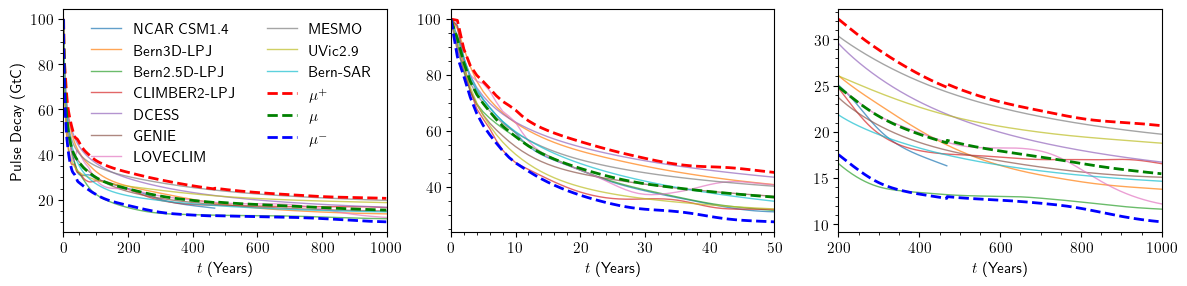

In [2]:
benchmark_list = ['NCAR','BERN3D','BERN25D', 'CLIMBER2','DCESS','GENIE','LOVECLIM','MESMO','UVIC29','BERNSAR']#['NCAR','BERN3D','BERN25D', 'CLIMBER2','DCESS','GENIE','LOVECLIM','MESMO','UVIC29','BERNSAR']

fig, axs = make_plot(1,3,[1,1])
for i,benchmark_i in enumerate(benchmark_list):
    [d,name] = data_load.pulse_fraction(test_type=benchmark_i,T=1000) 

    d= d*100

    t = min(1000,len(d))

    axs[0,0].plot(range(0,len(d)),d,label=name,linewidth=1,alpha=.7)
    axs[0,1].plot(range(0,51),d[0:51],label=name,linewidth=1,alpha=.7)
    axs[0,2].plot(range(200,t),d[200:t],label=name,linewidth=1,alpha=.7)


benchmark_list = ['MMMU','MMM','MMMD']#['NCAR','BERN3D','BERN25D', 'CLIMBER2','DCESS','GENIE','LOVECLIM','MESMO','UVIC29','BERNSAR']
color_set=['red','green','blue']
for i,benchmark_i in enumerate(benchmark_list):
    [d,name] = data_load.pulse_fraction(test_type=benchmark_i,T=1000) 

    d= d*100
    t = min(1000,len(d))

    axs[0,0].plot(range(0,len(d)),d,    color=color_set[i],label=name,linewidth=2,alpha=1,linestyle='--')
    axs[0,1].plot(range(0,51),d[0:51],  color=color_set[i],label=name,linewidth=2,alpha=1,linestyle='--')
    axs[0,2].plot(range(200,t),d[200:t],color=color_set[i],label=name,linewidth=2,alpha=1,linestyle='--')


axs[0,0].set_ylabel(r'Pulse Decay (GtC)')
axs[0,0].set_xlabel(r'$t$ (Years)')
axs[0,1].set_xlabel(r'$t$ (Years)')
axs[0,2].set_xlabel(r'$t$ (Years)')
axs[0,0].minorticks_on()
axs[0,1].minorticks_on()
axs[0,2].minorticks_on()
axs[0,0].set_xlim(0,1000)
axs[0,1].set_xlim(0,50)
axs[0,2].set_xlim(200,1000)
axs[0,0].legend(frameon=False,ncol=2)

fig.savefig('doc/fig/pulse.png', dpi=300)


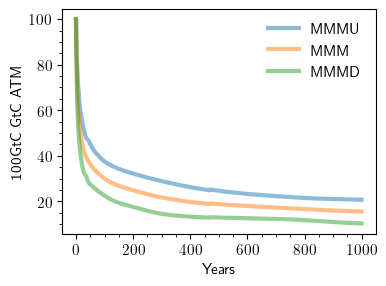

In [3]:
#_benchmark_list_sel = ['DCESS','MMM','BERN25D','NCAR']
_benchmark_list_sel = ['MMMU','MMM','MMMD']

fig, axs = make_plot(1,1,[1,1])
_data_pulse=[0] * len(_benchmark_list_sel)

for i,benchmark_sel in enumerate(_benchmark_list_sel):
    [_data_pulse[i],_] = data_load.pulse_fraction(test_type=benchmark_sel,T=_T) 

    _data_pulse[i]=_data_pulse[i]* 100
    axs[0,0].plot(_data_pulse[i],label=benchmark_sel,linewidth=3,alpha=0.5)

axs[0,0].set_ylabel(r'100GtC GtC ATM')
axs[0,0].set_xlabel(r'Years')
axs[0,0].minorticks_on()
axs[0,0].legend(frameon=False)

In [4]:
_metric_loss  = []
_metric_pen_1 = []
_metric_pen_2 = []
_metric_pen_3 = []

def constraints(
    z:np.array,
    model: callable,
    )->float:

    global _Max_TS
    global _data_pulse
    
    [a_size,m_size,info]=model()

    k = len(_data_pulse)
    a_set    = np.array_split(z[0:a_size*k],k)
    m_set    = [0]*k
    m_set[0] = z[a_size*k:]
    for i in range(1,k):
        m_set[i] = m_set[0]
    
    c  = 0
    
    for i in range(0,k):
        
        [A,m_eq,x_vec]    = model(a_set[i],m_set[i])
        [eig_val,eig_vec] = operations.eig(A)
        eig_val_trim      = eig_val[np.abs(eig_val)>1e-12]
        time_scale        = 1.0/np.abs(eig_val_trim)
        
        # !! Do not accept complex or postive eigen values!
        # !! Condition we do NOT accept
        # These condition can really help zero-order optimizers 
        
        # Real Eigen Values
        # abs sum of imaginary part of eigs = 0
        c += np.sum( np.abs(eig_val.flatten().imag)) + np.sum(np.abs(eig_vec.flatten().imag))
        
        # Negative Eigen Values
        # abs sum of all postive eigen values = 0
        c += np.sum(np.abs(eig_val[eig_val>0]))
        
        # Time Scales in range [1,1e8] years )
        # sum of timescales less than 1 and sum of time scales more than 100 million = 0
        c += np.sum(time_scale[time_scale<1]) + np.sum(time_scale[time_scale>_Max_TS])

        # no negative m_eq
        c += np.abs(np.sum( m_eq[m_eq<0] ))
                 
    return c

def obj_fun(
    z:np.array,
    model:callable,
    rho:list,
    )->float:
    
    global _data_pulse
    global _metric_loss
    global _metric_pen_1
    global _metric_pen_2
    global _metric_pen_3
    global _T
    
    [a_size,m_size,info]=model()
    
    # identify ocean and land reservoirs
    inx_ocean = []
    inx_land  = []

    for m_i_name in info['m_names']:
        if 'O_' in m_i_name:
            inx_ocean.append(info['m_names'].index(m_i_name))
        elif 'L_' in m_i_name:
            inx_land.append(info['m_names'].index(m_i_name))

    k = len(_data_pulse)
    a_set    = np.array_split(z[0:a_size*k],k)
    m_set    = [0]*k
    m_set[0] = z[a_size*k:]
    for i in range(1,k):
        m_set[i] = m_set[0]

    m0    = np.zeros(info['p'])
    m0[0] = 100

    loss  = 0
    pen_1 = 0
    pen_2 = 0
    pen_3 = 0
    
    for i,pulse_benchmark_i in enumerate(_data_pulse):

        [A,m_eq,x_vec] = model(a_set[i],m_set[i])
        p              = A.shape[0]

        ############################################################
        # error metrics for 100GtC pulse at T=50
        ############################################################
        m_sim       = operations.simulate_pulse(A=A,m0=m0,T=_T)
        m_benchmark = pulse_benchmark_i
        

        loss += operations.l2_err(m_sim[0,:],m_benchmark)

        ############################################################
        # max flux and displacment
        ############################################################ 
        #pen_1 += np.linalg.norm( A-A.T + np.diag(A), ord='fro' )
        #pen_1 += np.linalg.norm( A-A.T , ord='fro' ) - np.trace(np.abs(A))/A.shape[0]
        #pen_1 +=  np.linalg.norm(A - A.T,ord='fro') 
        #pen_1 +=  np.linalg.norm( a_set[i] -a_set[1]) 
        pen_1 +=  np.linalg.norm( a_set[i] -a_set[1]) /len(a_set)
        
        #pen_2 += -np.abs(np.trace(A))/A.shape[0] #np.linalg.norm( A-A.T , ord='fro' ) #+ np.linalg.norm(A,ord='fro')
        pen_2 += np.trace(A)/A.shape[0]
        
        ############################################################
        # compute difference betwee carbon absorved by oceans and lands at t=50
        ############################################################
        # we done have oceans/land ignore not relevant
        if len(inx_ocean)==0 or len(inx_land)==0:
            dif_t50_l2=0
        else:
            T      = 50
            m_T    = m_sim[:,T]
            temp   = [np.sum(m_T[inx_ocean]),np.sum(m_T[inx_land]) ]
            diff   = np.diff(temp)/(np.sum(temp)+1e-12)
            dif_t50_l2 = np.linalg.norm(diff)
                
        pen_3+=dif_t50_l2

    _metric_loss.append(loss)
    _metric_pen_1.append(pen_1)
    _metric_pen_2.append(pen_2)
    _metric_pen_3.append(pen_3)
    
    return loss + pen_1*rho[0] + pen_2*rho[1]  + pen_3*rho[2] 

In [5]:
def fit_model(
    folder_name:str,
    model:callable,
    rho:list,
    seed:int=1,
    verbose:bool=False
    )->list:

    global _data_pulse

    k =  len(_data_pulse)

    folder_name = str(folder_name)

    try:
        os.makedirs(folder_name)
    except:
        return [False,None]

    logging.root.handlers = []
    
    if verbose:
        logging.basicConfig(
            format='%(asctime)s:%(levelname)s:%(message)s', 
            level=logging.INFO,
            datefmt='%H:%M:%S',
            handlers=[
                logging.FileHandler(folder_name+'/opt.log'),
                logging.StreamHandler(sys.stdout)
                ])
    else:
        logging.basicConfig(
            format='%(asctime)s:%(levelname)s:%(message)s', 
            level=logging.INFO,
            datefmt='%H:%M:%S',
            handlers=[
                logging.FileHandler(folder_name+'/opt.log')
                ])
        
    logging.info('GENERAL:seed:'+str(seed))
    logging.info('GENERAL:rho:'+str(rho))

    [a_size,m_size,info]=model()

    # a values change per model and m values are fixed
    bounds_z = info['a_bounds']*k +info['m_bounds']
            
    logging.info('GENERAL:bounds_z:'+str(bounds_z))  

    z0 = np.mean(np.array(bounds_z),1)
    
    res = scipy.optimize.differential_evolution(
        func        = obj_fun,
        bounds      = bounds_z,
        args        = (model,rho,),
        maxiter     = int(1e6),
        #mutation    = (0.8, 1),
        tol         = 1e-3,
        polish      = False,
        seed        = seed,
        x0          = z0,
        constraints = (scipy.optimize.NonlinearConstraint( lambda z: constraints(z,model),0,0))
        )

    for key in res:
        if type(res[key]) is np.ndarray:
            logging.info('OPTIMIZER:'+str(key)+':\n'+str(res[key]))
        else:
            logging.info('OPTIMIZER:'+str(key)+':'+str(res[key]))
            
    # split optimizer into its component
    z = res.x

    a_set    = np.array_split(z[0:a_size*k],k)
    m_set    = [0]*k
    m_set[0] = z[a_size*k:]
    for i in range(1,k):
        m_set[i] = m_set[0]

    result={}
    result['A']     = [0]*k
    result['m_eq']  = [0]*k
    result['x_vec'] = [0]*k

    for i in range(0,k):
        [A,m_eq,x_vec]              = model(a_set[i],m_set[i])
        x_vec                       = np.concatenate((a_set[i],m_set[i]))+1e-12
        [eig_val,eig_vec]           = operations.eig(A)
        [eig_val_left,eig_vec_left] = operations.eig(A.T)

        logging.info('RESULT['+str(i)+']:A:\n'+str(A))
        logging.info('RESULT['+str(i)+']:m_eq:\n'+str(m_eq)+'('+str(np.sum(m_eq))+')')
        logging.info('RESULT['+str(i)+']:x_vec:\n'+str(x_vec)+'('+str(np.sum(x_vec))+')')
        logging.info('RESULT['+str(i)+']:time_scale:\n'+str(1/np.abs(eig_val[:-1])))
    
        result['A'][i]     = A
        result['m_eq'][i]  = m_eq
        result['x_vec'][i] = x_vec
        
    if folder_name is not None:
        logging.info('SAVE:message:saving bunch of data...')
        with open(folder_name+'/result.pkl', 'wb') as f:
            pickle.dump(result,f)

    return [res.success,result]

In [6]:
def run(rho,model,test_name='result'):
    
    global _metric_loss
    global _metric_pen_1
    global _metric_pen_2
    global _metric_pen_3
    
    rho = [float(rho_i) for rho_i in rho ]
    
    [a_size,m_size,info]=model()

    fl_name = test_name+'/'+'_'.join(_benchmark_list_sel)+'-'+ '_'.join(map(str, rho))+'/'+str(info['name'])
    print('\nRunning:',fl_name)
    
    [succ,result] = fit_model(
        folder_name=fl_name,
        model=model,
        rho=rho,
        )

    fig, axs = make_plot(1,3)
    
    axs[0,0].plot(_metric_loss)
    axs[0,0].set_title('_metric_loss')
    
    axs[0,1].plot(_metric_pen_1)
    axs[0,1].set_title('_metric_pen_1')
    
    axs[0,2].plot(_metric_pen_2)
    axs[0,2].set_title('_metric_pen_2')

    plt.savefig(fl_name+'/plt_metrics.pdf', format='pdf',bbox_inches='tight')
    plt.close()
    
    _metric_loss  = []
    _metric_pen_1 = []
    _metric_pen_2 = []
    print('\n>>>>>> Done:',fl_name,' succ=',succ)

In [8]:
import multiprocess as mp

#rho1_set = [0.0, 0.005, 0.01, 0.05, 0.1, 1.0] # ||a_mmm -a_i || : keep variables constnate between models
#rho2_set = [0.0, 0.005, 0.01, 0.05, 0.1, 1.0] # -tr(A)/p : Reudce average time-scales
#rho3_set = [0.0, 0.005, 0.01, 0.05, 0.1, 1.0] # F_i : Situation enforcement

rho1_set = np.array([0]+list(2**np.arange(0,8,1)))*0.001 # ||a_mmm -a_i || : keep variables constnate between models
rho2_set = np.array([0]+list(2**np.arange(0,8,1)))*0.001 # -tr(A)/p : Reudce average time-scales
rho3_set = np.array([0]+list(2**np.arange(0,8,1)))*0.001 # F_i : Situation enforcement

rho_set   = [[rho1,rho2,rho3] for rho1 in rho1_set for rho2 in rho2_set for rho3 in rho3_set] 

model_set       = [model_4pr,model_3sr]
task_input_list = [[rho,model_tempate] for model_tempate in model_set for rho in rho_set] 

run_mask = lambda tak_input: run(test_name='result/new_650/15_1.0x/T-'+str(_T)+'_tau-'+str(_Max_TS),rho=tak_input[0],model=tak_input[1])

with mp.Pool( min( int(mp.cpu_count()/2), int(len(task_input_list)*2))) as pool:
    restult = pool.map(run_mask, task_input_list)


Running:
Running:
Running:
Running:
Running:  
Running:   result/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.0_0.003_0.0/4PR result/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.0_0.0_0.0/4PRresult/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.001_0.0_0.0/4PRresult/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.001_0.003_0.0/4PRresult/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.002_0.0_0.0/4PR
result/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.002_0.003_0.0/4PR





>>>>>> Done: result/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.002_0.003_0.0/4PR  succ= False

Running: result/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.002_0.003_0.001/4PR

>>>>>> Done: result/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.001_0.003_0.0/4PR  succ= False

Running: result/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.001_0.003_0.001/4PR

>>>>>> Done: result/new_650/15_1.0x/T-1000_tau-10000/MMMU_MMM_MMMD-0.0_0.003_0.0/4PR  succ= False

Running: result/new_650/15_1.0x/